<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/optuna_and_bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 8th July, 2021
# Myfolder: C:\Users\Administrator\OneDrive\Documents\breast_cancer
#
# Ref: https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
#      https://github.com/optuna/optuna/blob/master/examples/lightgbm_tuner_simple.py
#
# Objective:
#           i) Learn to use automated tuning of lightgbm
#          ii) Using optuna
#         iii) Perform Bayesian optimization
#
# See also 'h2o_talkingData.ipynb' in folder:
#   C:\Users\Administrator\OneDrive\Documents\talkingdata

In [ ]:
"""
Optuna example that optimizes a classifier configuration
for cancer dataset using LightGBM tuner.
In this example, we optimize the validation log loss of
cancer detection.

"""

### Install libraries

In [1]:
# Downgrade sklearn
# Higher version gives problem with BayesSearchCV

! pip install scikit-learn==0.23.2 
import sklearn
sklearn.__version__

'0.23.2'

In [ ]:
# 0.0 Optuna
#     https://optuna.org/
! pip install optuna

In [ ]:
# 0.1 sklearn optimizer
# 
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'

In [ ]:
# 0.2 Lightgbm
! pip install lightgbm --upgrade
import lightgbm
lightgbm.__version__

In [5]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import sklearn.datasets
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1.1 Import optuna integration with lightgbm
# Install as: conda install -c conda-forge optuna

import optuna.integration.lightgbm as lgbm


# 1.2  Return stratified folds. The folds are made by
#      preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

# 1.3 ML - we will classify using lightgbm
#          with stratified cross validation
#      conda install -c conda-forge lightgbm 
import lightgbm as lgb

# 1.4 OS related
import os, time

# 1.5 Bayes optimization--IInd method
# SKOPT is a parameter-optimisation framewor
#  Install skopt as:
#     conda install -c conda-forge scikit-optimize


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [6]:
# 1.6
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [7]:
# # 2.0 Get data and split it
data,target = make_classification( n_samples = 10000,
                          n_features = 20,
                          n_informative = 10,
                          n_redundant = 2,
                          n_repeated = 3,
                          n_classes = 2,
                          flip_y = 0.01,
                          shuffle = True)

# 2.0.1
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)

In [8]:
# 2.1 Transform train_x and val_x to lightgbm data-matricies

dtrain = lgbm.Dataset(train_x, label=train_y)

dval = lgbm.Dataset(val_x, label=val_y)

In [9]:
# 3.0 Set fixed hyper-params
params_fixed = {                           # Specify params that are fixed
                 "objective": "binary",
                 "metric": "binary_logloss",
                 "verbosity": -1,
                 "boosting_type": "gbdt",
                }

In [ ]:
# 3.1 Note that unlike in sklearn, here there is
#     no instantiation of LightGBM model
#     Start modeling as also tuning hyperparameters

model = lgbm.train(
                   params_fixed,               # Just fixed params only
                   dtrain,                     # Dataset
                   valid_sets=[dtrain, dval],  # Evaluate performance on these datasets
                   verbose_eval=100,
                   early_stopping_rounds=100
                  )


In [26]:
# 3.2 This predicts probabilities:
model.predict(
                val_x,    # Note that it is not lightgbm dataset
                num_iteration = model.best_iteration
             )

array([0.99928656, 0.99857031, 0.01245339, ..., 0.79202204, 0.47443469,
       0.99988537])

In [27]:
### Model is ready
# 4.0 Make prediction
#     np.rint: Round elements of the array to the nearest integer. 
#     For values exactly halfway between rounded decimal values,
#     NumPy rounds to the nearest even value. Thus 1.5 and 2.5 
#     round to 2.0, -0.5 and 0.5 round to 0.0, etc.

prediction = np.rint(
                     model.predict(
                                    val_x,    # Note that it is not lightgbm dataset
                                    num_iteration = model.best_iteration
                                    )
                    )

# 4.0.1
prediction

array([1., 1., 0., ..., 1., 0., 1.])

In [ ]:
# 4.1 Determine accuracy
accuracy = accuracy_score(val_y, prediction)

# 4.2 Get best params
best_params = model.params
print("\nbest_params: " ,best_params) 
print("\n===============")
print("\nAccuracy: ", accuracy)
print("\n===============")

# 4.3
for key, value in best_params.items():
    print("\n    {}: {}".format(key, value))

######################


## Bayesian optimization

#### Model Object

In [10]:
# 5.0. Define classifier object:

model_lgb = lgb.LGBMRegressor(                # Regressor will also perform classification
                                objective='binary',
                                metric='auc', # This output must match with what
                                          #  we specify as input to Bayesian model
                                n_jobs=2,
                                verbose=0,
                                #baggeng_freq=1,
                                #bagging_fraction =0.8,
                              )

#### Parameter space

In [11]:
# 5.1 Parameter search space for selected modeler
#      For suggested parameter grid for lightgbm, pl see: 
#         https://github.com/Microsoft/LightGBM/issues/695
#
params = {
        # The 'boosting' option parameter give lots of errors. 
        # Do not use it. (Removed 'rf' from it. Avoids errors)
        'boosting'    :   Categorical(['gbdt','dart']),                                                         
        'n_estimators':   Integer(50, 100), # No of boosted trees or iterations to fit (default: 100).

        'num_leaves'  :   Integer(5,45),   # Max tree leaves for base boosters
                                           # Create a node only if no of leaves exceed this limit
                                           #  and also following condition of 'min_child_samples' is met

        'min_child_samples': Integer(1, 50),  # Create a node only if min data-points at this node
                                              #  exceed this limit

        'feature_fraction' : Real(0.1, 0.9),  # Randomly select part of features on each iteration
                                              #  for every boosted tree

        'bagging_fraction' : Real(0.8, 1),   # Randomly select part of data without resampling
                                             #   for each boosted tree

        'bagging_freq'     : Integer(1,10),  # k means perform bagging at every k iteration

        'max_depth'        : Integer(1, 50), # Max tree depth for base learners, -1 means no limit.

        'learning_rate': Real(0.01, 1.0, 'log-uniform'), # Prob of interval 1 to 10 is same as 10 to 100
                                                         # Equal prob of selection from 0.01 to 0.1, 0.1
                                                         # to 1
                                                         # In a loguniform distributon, log-transformed
                                                         # random variable is uniformly distributed

        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),  # L2 regularization term on weights.
        'reg_alpha':  Real(1e-9, 1.0, 'log-uniform'),   #  L1 regularization

        'scale_pos_weight': Real(1, 10),    # default: 1
                                            # used only in binary application
                                            # How much more importance should be given to binary
                                            # weight of labels with positive class

        #-----***** Not understood **** -----

        'max_bin': Integer(100, 1000),      # max number of bins that feature
                                            #  values will be bucketed in
                                            # small number of bins may reduce
                                            # training accuracy but may increase
                                            # general power (deal with over-fitting)

        'min_child_weight':  Real(1, 10),   # Deals with overfitting

        'subsample_for_bin': Integer(100000, 500000)  #  Number of samples for constructing bins(default: 200000)
                                               # setting this to larger value will give better training
                                               #  result, but will increase data loading time
           }



#### Cross validation strategy

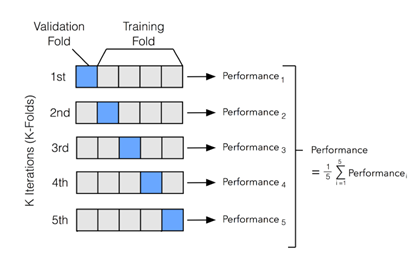

In [12]:
# 5.2 Cross validation strategy for the modeler
#      Perform startified k-fold cross-validation
#      There is also RepeatedStratifiedKFold() class
#      that will repeat startified k-fold N-number
#      of times
#      Instantiate cross-vlidation object
"""
Examples of Cross-validation strategies:
    i)   Leave one out  : Very time consuming
    ii)  Leave P out    : For example, leave 2 out
    iii) kfold          : k-equal random folds
    iv)  StratifiedKFold : kfolds + stratification
    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs
                          of (train,test). For examples, in each
                          (train,test) pair, let number of rows
                          of 'test' data be 30% of train data

"""

cvStrategy = StratifiedKFold(
                             n_splits=3,
                             shuffle=True,
                             random_state=42
                            )

"\nExamples of Cross-validation strategies:\n    i)   Leave one out  : Very time consuming\n    ii)  Leave P out    : For example, leave 2 out\n    iii) kfold          : k-equal random folds\n    iv)  StratifiedKFold : kfolds + stratification\n    v)   ShuffleSplit  => Generate n-numbers of userdefined pairs\n                          of (train,test). For examples, in each\n                          (train,test) pair, let number of rows\n                          of 'test' data be 30% of train data\n\n"

#### Bayes tuner object

In [13]:
# 5.3 Bayesian object instantiation
#     For API, refer: https://scikit-optimize.github.io/#skopt.BayesSearchCV
#     For example: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

start = time.time()
bayes_cv_tuner = BayesSearchCV(
                              estimator = model_lgb,    # rf, lgb, xgb, nn , pipeline etc--Black box
                              search_spaces = params,  # Specify params as required by the estimator
                              scoring = 'roc_auc',  # Input to Bayes function
                                                    # modeler should return this
                                                    # peformence metric
                              cv = cvStrategy,      # Optional. Determines the cross-validation splitting strategy.
                                                    #           Can be cross-validation generator or an iterable,
                                                    #           Possible inputs for cv are: - None, to use the default 3-fold cv,
                                                    #           - integer, to specify the number of folds in a (Stratified)KFold,
                                                    #           - An object to be used as a cross-validation generator.
                              n_jobs = 2,           # Start two parallel threads for processing
                              n_iter = 10,        # How many times to look for parameter sets
                              verbose = 1,
                              refit = True,       #  Refit the best estimator with the entire dataset
                              random_state = 42
                               )
end = time.time()
(end-start)/60

5.356470743815104e-06

#### Begin tuning

In [ ]:
# 5.4 Start learning using Bayes tuner

start = time.time()
result = bayes_cv_tuner.fit(
                            train_x,       # Note that we use normal train data
                            train_y,       #  rather than lgb train-data matrix
                            #callback=status_print
                           )

end = time.time()
(end - start)/60


#### Results

In [16]:
# 6.0 So what are the results?
#      Use the following estimator in future
#      What parameters the best estimator was using?

best_params = pd.Series(bayes_cv_tuner.best_params_)
print(best_params)

# 6.1 Best auc score for the above estimator

print("\n\nBest score: ", np.round(bayes_cv_tuner.best_score_, 4))


bagging_fraction        0.923416
bagging_freq                   8
boosting                    dart
feature_fraction         0.79946
learning_rate           0.153193
max_bin                      635
max_depth                     33
min_child_samples             22
min_child_weight         7.60494
n_estimators                  82
num_leaves                    42
reg_alpha            0.000833057
reg_lambda             0.0219248
scale_pos_weight         4.11378
subsample_for_bin         287406
dtype: object


Best score:  0.9803


In [17]:
# 6.2 Summary of all models developed by Bayes process

allModels_summary = pd.DataFrame(bayes_cv_tuner.cv_results_)
allModels_summary.shape  # 50 X 26 ; 50 iterations

# 17.3
allModels_summary.head()

(10, 26)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_boosting,param_feature_fraction,param_learning_rate,param_max_bin,param_max_depth,param_min_child_samples,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample_for_bin,params
0,0.976999,0.977463,0.974857,0.976440,0.001135,3,0.702537,0.311060,0.021811,0.006333,0.882021,8,gbdt,0.352640,0.218925,473,18,37,3.740170,82,27,1.385174e-08,1.370904e-07,6.688861,131156,"{'bagging_fraction': 0.8820207917706628, 'bagg..."
1,0.980483,0.980932,0.978493,0.979969,0.001060,2,5.272465,3.297048,0.038632,0.016431,0.967478,9,dart,0.860979,0.534879,156,8,18,6.721562,98,30,8.524050e-01,1.590337e+00,4.496724,342928,"{'bagging_fraction': 0.9674776711106569, 'bagg..."
2,0.945151,0.952531,0.936246,0.944643,0.006658,9,1.585780,0.729317,0.029046,0.011230,0.888967,9,dart,0.446666,0.023763,508,9,38,6.016064,99,33,2.711809e-06,2.367361e-07,5.585960,278139,"{'bagging_fraction': 0.8889665024602303, 'bagg..."
3,0.976621,0.976025,0.973043,0.975230,0.001565,4,0.739239,0.399895,0.022771,0.008165,0.962479,3,gbdt,0.742212,0.111200,186,38,44,9.207360,69,19,3.449623e-02,2.114410e-02,1.236578,485880,"{'bagging_fraction': 0.9624791976714727, 'bagg..."
4,0.974006,0.976800,0.970314,0.973707,0.002657,5,1.206950,0.558106,0.023425,0.007199,0.959911,5,gbdt,0.672571,0.642250,745,22,33,4.177755,83,26,8.740059e-02,1.165902e-06,3.383559,207155,"{'bagging_fraction': 0.9599106883214347, 'bagg..."


In [ ]:
####### I am done #############